In [33]:
import numpy as np
import pandas as pd
import mne
import os
import logging 

import matplotlib.pyplot as plt
import seaborn as sns

from Function import *

In [34]:
# =============================================================================
# Configuration: Paths and Parameters
# =============================================================================
# Set up logging: messages will include timestamp, log level, and message content
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

PREPROCESSED_DATA_ROOT_MEM = '../data/preprocessData/Memory'
PREPROCESSED_DATA_ROOT_PERC = '../data/preprocessData/Perception'

BIDS_TASK_LABEL_MEM = '_task-memoryBasedDecisionMaking'
BIDS_TASK_LABEL_PERC = '_task-perceptionBasedDecisionMaking'
BIDS_BEH_SUFFIX = '_beh'
BIDS_EEG_SUFFIX = '_eeg'

SAMPLING_RATE = 500

CHANNEL_INDICES = [26, 27, 28]

SUBJECT_DIR = [f'ACC{i:03}' for i in range(14, 37)]

In [ ]:
def calculate_rt_max (task_mode):
    # Set path to get joint modeling across subjects
    if task_mode == 'mem':
        path = '../results/Memory/joint_modeling/data_joint_modeling_across_subject.csv'
    else:
        path = '../results/Perception/joint_modeling/data_joint_modeling_across_subject.csv'

    # Load data to get max rt
    data_joint_modeling_across_subjects = pd.read_csv(path, header=0)
    rt_max = data_joint_modeling_across_subjects['rt'].max()/1000
    
    return rt_max

def load_behavior_data(sub_id, task_mode):
    if task_mode == 'mem':
        path = PREPROCESSED_DATA_ROOT_MEM
        BIDS_TASK_LABEL = BIDS_TASK_LABEL_MEM
    else:
        path = PREPROCESSED_DATA_ROOT_PERC
        BIDS_TASK_LABEL = BIDS_TASK_LABEL_PERC
    
    # Set path for behavior
    path_behavior = os.path.join(path,
                                 'sub-'+sub_id,
                                 'beh',
                                 'sub-'+sub_id+BIDS_TASK_LABEL+BIDS_BEH_SUFFIX+'.tsv')
    assert os.path.exists(path_behavior), f"{sub_id} : behavior file not found: {path_behavior}"
    
    # Load behavior data
    data_behavior = pd.read_csv(path_behavior, sep='\t', header=0)
    data_behavior['subj_idx'] = sub_id
    data_behavior['rt'] = data_behavior['rt']/1000

    return data_behavior


def load_eeg_data(sub_id, task_mode):
    if task_mode == 'mem':
        path = PREPROCESSED_DATA_ROOT_MEM
        BIDS_TASK_LABEL = BIDS_TASK_LABEL_MEM
    else:
        path = PREPROCESSED_DATA_ROOT_PERC
        BIDS_TASK_LABEL = BIDS_TASK_LABEL_PERC
    path_eeg = os.path.join(path,
                            'sub-'+sub_id,
                            'eeg',
                            'sub-'+sub_id+BIDS_TASK_LABEL+BIDS_EEG_SUFFIX+'.vhdr')
    assert os.path.exists(path_eeg), f"{sub_id} : eeg file not found: {path_eeg}"

    # Load eeg data
    eeg_bids = mne.io.read_raw_brainvision(path_eeg, preload=False)
    events, event_id = mne.events_from_annotations(eeg_bids)

    data_eeg = eeg_bids.get_data() 
    n_timestamps = data_eeg.shape[1]

    return eeg_bids, events, event_id, data_eeg, n_timestamps

def remove_rt_outlier(data_behavior, events, event_id, events_id_response, RT_OUTLIER_STD_MULTIPLIER=3):

    # Calculate the boundary of rt
    rt_mean = np.nanmean(data_behavior['rt'])
    rt_std = np.nanstd(data_behavior['rt'])
    rt_lower = rt_mean - RT_OUTLIER_STD_MULTIPLIER * rt_std
    rt_upper = rt_mean + RT_OUTLIER_STD_MULTIPLIER * rt_std

    mask_data_behavior_clean = (
        (data_behavior['rt'] >= rt_lower) &
        (data_behavior['rt'] <= rt_upper)
    )

    index_data_behavior_clean = np.where(mask_data_behavior_clean)[0]

    # Remove outlier trials
    data_behavior_clean = data_behavior.iloc[index_data_behavior_clean].reset_index(drop=True)

    # Remove outlier events
    event_id_key_response = {events_id_response: event_id[events_id_response]}
    events_response = events[events[:, 2] == event_id_key_response[events_id_response]]
    events_clean = events_response[index_data_behavior_clean]

    n_data_behavior_clean = len(data_behavior_clean)
    n_events_clean = len(events_clean)
    # Confirm that the number of response events matches the number of behavioral trials
    assert n_events_clean == n_data_behavior_clean, f"Trial count mismatch! EEG: {n_events_clean}, Behavior: {n_data_behavior_clean}"

    return data_behavior_clean, events_clean

def prepare_cpp_plot(data_behavior_clean, events_clean, data_eeg, n_timestamps, rt_max):
    
    data_merged_beh_trigger = pd.DataFrame({
        'subject_id': data_behavior_clean['subj_idx'].values,
        'reaction_time_sec': data_behavior_clean['rt'].values,
        'trigger_sample': events_clean[:, 0]
    })
    
    data_merged_beh_trigger['epoch_start_sample'] = np.round(
        np.maximum(0, data_merged_beh_trigger['trigger_sample'] - (data_merged_beh_trigger['reaction_time_sec'] + 0.5) * SAMPLING_RATE)
    ).astype(int)

    data_merged_beh_trigger['epoch_end_sample'] = np.round(
        np.minimum(n_timestamps, data_merged_beh_trigger['trigger_sample'] + (rt_max - data_merged_beh_trigger['reaction_time_sec']) * SAMPLING_RATE)
    ).astype(int)

    # Compute CPP: average over selected channels
    data_erp = data_eeg[CHANNEL_INDICES, :].mean(axis=0)

    data_single_trials_per_subject = []
    for _, trial_row in data_merged_beh_trigger.iterrows():
        start_idx = trial_row['epoch_start_sample']
        end_idx = trial_row['epoch_end_sample']

        # Get segment erp
        data_erp_segment = data_erp[start_idx:end_idx]

        # Build trial record: metadata + timepoint amplitudes
        data_single_trial = {
            'subject_id': trial_row['subject_id'],
            'reaction_time_sec': trial_row['reaction_time_sec']
        }

        for time_idx, amplitude in enumerate(data_erp_segment):
            data_single_trial[f't_{time_idx}'] = amplitude

        data_single_trials_per_subject.append(data_single_trial)

    return data_single_trials_per_subject


# Define a function for all data
def calculate_matrix_plot(data_single_trials_all):
    # replace NaNs with 0 (assumes missing ERP samples are negligible)
    data_single_trials_all = data_single_trials_all.fillna(0)

    # Identify cpp timepoint columns
    index_columns_cpp = [col for col in data_single_trials_all.columns if col.startswith('t_')]

    # Sort trials by reaction time (longest RT at top of heatmap)
    data_single_trials_all_sorted = data_single_trials_all.sort_values('reaction_time_sec', ascending=False).reset_index(drop=True)
    data_matrix4plot = data_single_trials_all_sorted[index_columns_cpp].values

    return data_matrix4plot, data_single_trials_all_sorted

# Define a function for plot
def plot_single_trial(data_matrix4plot, data_single_trials_all_sorted, v_min, v_max):
    n_trials, n_timestamps = data_matrix4plot.shape

    # === step 1: Create heatmap ===
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(
        data_matrix4plot,
        cmap='RdBu_r',
        center=0,
        xticklabels=False,
        yticklabels=False,
        vmin=v_min,
        vmax=v_max,
        cbar_kws={'label': 'Amplitude (µV)'}
    )
    data_rt_array = data_single_trials_all_sorted['reaction_time_sec'].to_numpy()
    # Time axis: t = -0.5 sec corresponds to column index 0
    # Therefore, RT (relative to stimulus) occurs at: t = RT → column = (RT + 0.5) * sampling_rate
    positions_rt_x = (data_rt_array + 0.5) * SAMPLING_RATE
    positions_rt_y = np.arange(n_trials)
    ax.plot(positions_rt_x, positions_rt_y, color='black', linewidth=2, label='Response time per trial')

    # === step 2: Set x-axis time labels ===
    # Total duration covered: from t = -0.5 sec to t = (n_timestamps / SAMPLING_RATE) - 0.5 sec
    time_vector_sec = np.arange(-0.5, (n_timestamps / SAMPLING_RATE) - 0.5 + 1e-9, 0.25)
    x_tick_indices = ((time_vector_sec + 0.5) * SAMPLING_RATE).astype(int)

    # Ensure indices are within bounds
    valid_ticks = (x_tick_indices >= 0) & (x_tick_indices < n_timestamps)
    ax.set_xticks(x_tick_indices[valid_ticks])
    ax.set_xticklabels([f"{t:.2f}" for t in time_vector_sec[valid_ticks]])

    # === step 3: Set y-axis trial labels ===
    y_tick_step = 500
    y_tick_positions = np.arange(0, n_trials, y_tick_step)

    # For correct visual alignment with "trial 0 at bottom",
    # we plot y = n_trials - 1 - i, but since we want labels to reflect actual trial order from bottom,
    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels(n_trials - 1 - y_tick_positions)  # Trial index as shown (0 = first row = top)

    # === step 4: Mark stimulus onset (t = 0) ===
    t0_column_index = int(0.5 * SAMPLING_RATE) 
    ax.axvline(x=t0_column_index, color='grey', linewidth=2, linestyle='--', label='Stimulus onset (t=0)')

    # === step 5: Finalize plot ===
    ax.set_xlabel('Time (s)')
    ax.set_title('Single-Trial ERP (Adult)')
    ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    

Extracting parameters from ../data/preprocessData/Memory/sub-ACC014/eeg/sub-ACC014_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Extracting parameters from ../data/preprocessData/Memory/sub-ACC015/eeg/sub-ACC015_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Extracting parameters from ../data/preprocessData/Memory/sub-ACC016/eeg/sub-ACC016_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Extracting parameters from ../data/preprocessData/Memory/sub-ACC017/eeg/sub-ACC017_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Extracting parameters from ../data/preprocessData/Memory/sub-ACC018/eeg/sub-ACC018_task-memoryBasedDecisionMaking_eeg.vhdr...
Se

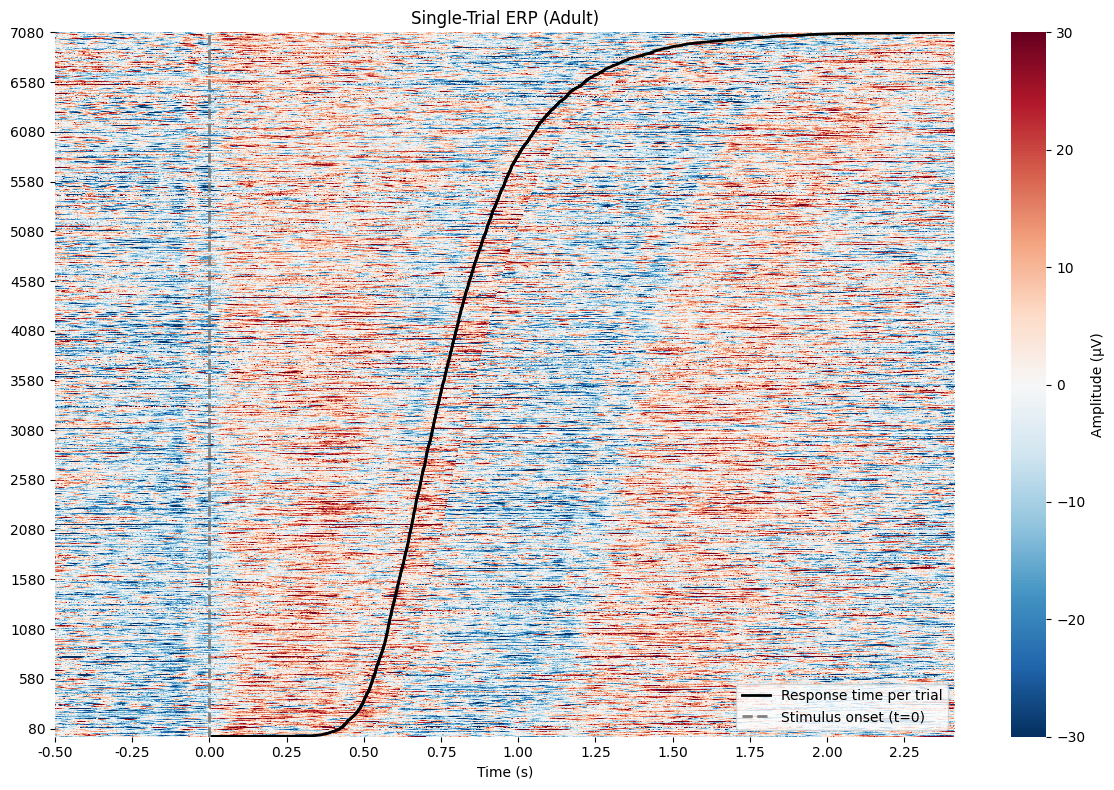

In [68]:
rt_max = calculate_rt_max('mem')
data_single_trials_all = []
for sub in SUBJECT_DIR:
    data_behavior_raw = load_behavior_data(sub, 'mem')
    eeg_bids, events, event_id, data_eeg, n_timestamps = load_eeg_data(sub, 'mem')
    data_behavior_clean, events_clean = remove_rt_outlier(data_behavior_raw, events, event_id, 'Stimulus/S  1', RT_OUTLIER_STD_MULTIPLIER=3)
    data_single_trials_per_subject = prepare_cpp_plot(data_behavior_clean, events_clean, data_eeg, n_timestamps, rt_max)

    data_single_trials_per_subject = pd.DataFrame(data_single_trials_per_subject)
    data_single_trials_all.append(data_single_trials_per_subject)

data_single_trials_all = pd.concat(data_single_trials_all, ignore_index=True)

data_matrix4plot, data_single_trials_all_sorted = calculate_matrix_plot(data_single_trials_all)
plot_single_trial(data_matrix4plot, data_single_trials_all_sorted, v_min=-30, v_max=30)

Extracting parameters from ../data/preprocessData/Perception/sub-ACC014/eeg/sub-ACC014_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Extracting parameters from ../data/preprocessData/Perception/sub-ACC015/eeg/sub-ACC015_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Extracting parameters from ../data/preprocessData/Perception/sub-ACC016/eeg/sub-ACC016_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Extracting parameters from ../data/preprocessData/Perception/sub-ACC017/eeg/sub-ACC017_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Extracting parameters from ../data/preprocessData/Perception/sub-ACC018/eeg/sub-ACC018_task-perc

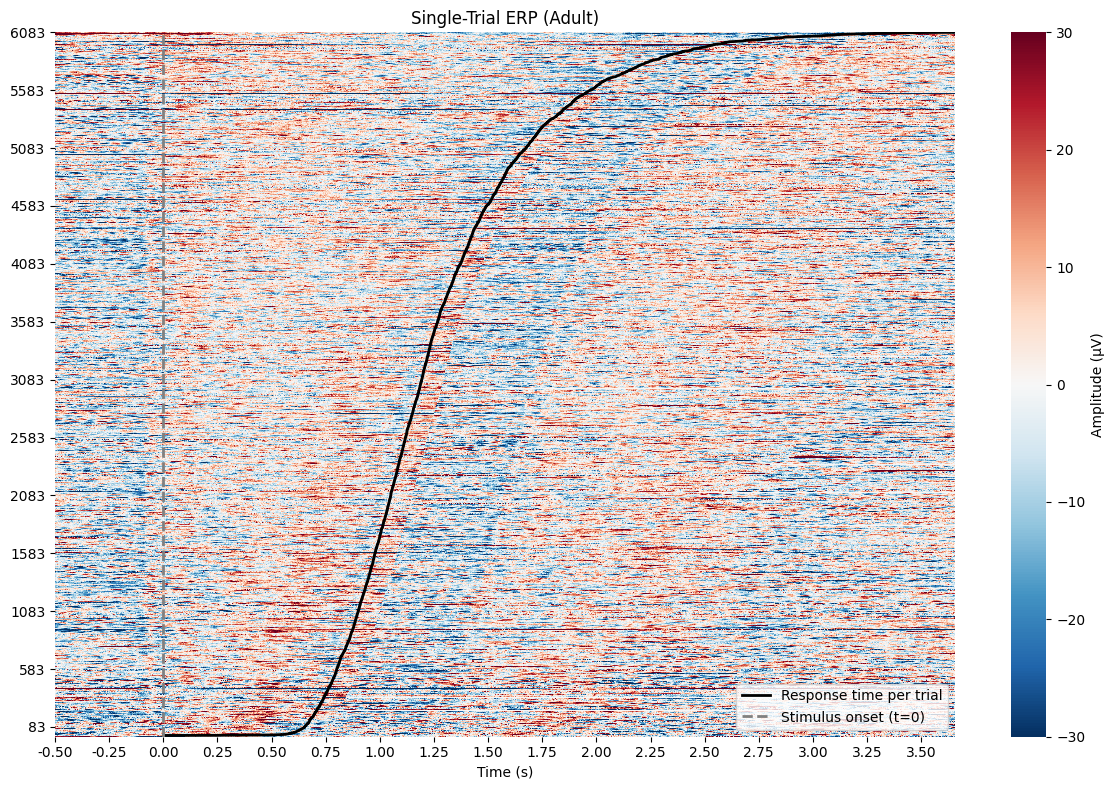

In [67]:
rt_max = calculate_rt_max('perc')
data_single_trials_all = []
for sub in SUBJECT_DIR:
    data_behavior_raw = load_behavior_data(sub, 'perc')
    eeg_bids, events, event_id, data_eeg, n_timestamps = load_eeg_data(sub, 'perc')
    data_behavior_clean, events_clean = remove_rt_outlier(data_behavior_raw, events, event_id, 'Stimulus/S  1', RT_OUTLIER_STD_MULTIPLIER=3)
    data_single_trials_per_subject = prepare_cpp_plot(data_behavior_clean, events_clean, data_eeg, n_timestamps, rt_max)

    data_single_trials_per_subject = pd.DataFrame(data_single_trials_per_subject)
    data_single_trials_all.append(data_single_trials_per_subject)

data_single_trials_all = pd.concat(data_single_trials_all, ignore_index=True)

data_matrix4plot, data_single_trials_all_sorted = calculate_matrix_plot(data_single_trials_all)
plot_single_trial(data_matrix4plot, data_single_trials_all_sorted, v_min=-30, v_max=30)